# **Neural Networks**

In [2]:
pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing install

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



In [4]:
# reading in the data via the Kaggle API

# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

In [6]:
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [7]:
# install Kaggle
! pip install kaggle

In [8]:
# download the dataset from the competition page
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

100% 303k/303k [00:00<00:00, 620kB/s]
100% 303k/303k [00:00<00:00, 620kB/s]


In [9]:
df_labeled = pd.read_csv("training_data.csv")
df_labeled.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [10]:
sentences_labeled = df_labeled["sentence"].to_numpy()
difficulty_labels = df_labeled["difficulty"]

Read the unlabelled test data, on which to make predictions.

In [11]:
df_unlabeled = pd.read_csv("/content/unlabelled_test_data.csv")
sentences_unlabeled = df_unlabeled["sentence"].to_numpy()
df_unlabeled.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


In [12]:
def encode_difficulty_levels(df, column_name):
    """
    Encode difficulty levels in the dataframe using Ordinal Encoder.
    """
    ordinal_encoder = OrdinalEncoder(categories=[['A1', 'A2', 'B1', "B2", "C1", "C2"]])
    df_encoded = pd.DataFrame(ordinal_encoder.fit_transform(df[[column_name]]), columns=["difficulty"])
    return df_encoded, ordinal_encoder.categories_

In [13]:
def embed_sentences(sentence_list):
    """
    Embed sentences using the Universal Sentence Encoder.
    """
    sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
    return pd.DataFrame(sentence_encoder(sentence_list).numpy())

In [14]:
def split_data(features, labels, test_size=0.2, valid_size=0.4, random_state=0):
    """
    Split the data into training, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=valid_size, random_state=random_state)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [15]:
def create_tf_dataset(dataframe, labels, shuffle=True, batch_size=30):
    """
    Create TensorFlow dataset from given dataframe and labels.
    """
    ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [16]:
def build_model():
    """
    Build and compile a Keras Sequential model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1064, activation="relu"),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(516, activation="relu"),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(6, activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="SparseCategoricalCrossentropy",
                  metrics=["accuracy"])
    return model

In [17]:
def plot_training_graphs(history, metric):
    """
    Plot training and validation graphs for a given metric.
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [34]:
def evaluate_model(model, test_dataset):
    """
    Evaluate the model on the test dataset and calculate evaluation metrics.
    """
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels = []
    for _, labels in test_dataset.unbatch():
      true_labels.extend(labels.numpy())

      evaluate_classification_metrics(true_labels, predicted_labels)

In [20]:
def evaluate_classification_metrics(true_labels, predicted_labels):
    """
    Calculate and print classification metrics including precision, recall, f1 score, and confusion matrix.
    """

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    confusion = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='.4g')
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title('Confusion Matrix')
    print('Accuracy score: {:0.4f}'.format(accuracy))
    print('Precision: {:0.4f}'.format(precision))
    print('Recall: {:0.4f}'.format(recall))
    print('F1 Score: {:0.4f}'.format(f1))
    return precision, recall, f1, accuracy

'\n    precision = precision_score(true_labels, predicted_labels, average=\'weighted\')\n    recall = recall_score(true_labels, predicted_labels, average=\'weighted\')\n    f1 = f1_score(true_labels, predicted_labels, average=\'weighted\')\n    print(f"CONFUSION MATRIX:\n{confusion_matrix(true_labels, predicted_labels)}")\n    print(f"ACCURACY SCORE:\n{accuracy_score(true_labels, predicted_labels):.4f}")\n    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")'

In [21]:
def generate_predictions_and_save(model, X_unlab):
    # Evaluate the model
    model.evaluate(X_unlab)

    # Generate predictions
    pred = model.predict(X_unlab)

    # Transform predictions to labels
    labels = pd.DataFrame(np.argmax(pred, axis=1), columns=["difficulty"])
    labels["difficulty"] = labels["difficulty"].map({0: "A1", 1: "A2", 2: "B1", 3: "B2", 4: "C1", 5: "C2"})
    labels["id"] = labels.index
    labels = labels[["id", "difficulty"]]

    # Save to CSV
    labels.to_csv('submission_nn10.csv', index=False)

    return labels


In [23]:
# Example usage
encoded_difficulty, _ = encode_difficulty_levels(df_labeled, "difficulty")

In [24]:
# Embed sentences
features_labeled = embed_sentences(df_labeled["sentence"].tolist())
features_unlabeled = embed_sentences(df_unlabeled["sentence"].tolist())

In [25]:
# Split data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(features_labeled, encoded_difficulty)

In [26]:
# Create datasets
train_dataset = create_tf_dataset(X_train, y_train, shuffle=True, batch_size=5)
valid_dataset = create_tf_dataset(X_valid, y_valid, shuffle=False, batch_size=5)
test_dataset = create_tf_dataset(X_test, y_test, shuffle=False, batch_size=5)

In [27]:
# Build and train model
model = build_model()
training_history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
768/768 [==============================] - 18s 22ms/step - loss: 1.7655 - accuracy: 0.2307 - val_loss: 1.6688 - val_accuracy: 0.3819
Epoch 2/10
768/768 [==============================] - 13s 17ms/step - loss: 1.5220 - accuracy: 0.3661 - val_loss: 1.2959 - val_accuracy: 0.4549
Epoch 3/10
768/768 [==============================] - 15s 19ms/step - loss: 1.3224 - accuracy: 0.4133 - val_loss: 1.1911 - val_accuracy: 0.5139
Epoch 4/10
768/768 [==============================] - 14s 18ms/step - loss: 1.2433 - accuracy: 0.4680 - val_loss: 1.1554 - val_accuracy: 0.5208
Epoch 5/10
768/768 [==============================] - 14s 19ms/step - loss: 1.1973 - accuracy: 0.4823 - val_loss: 1.1310 - val_accuracy: 0.5382
Epoch 6/10
768/768 [==============================] - 13s 17ms/step - loss: 1.1367 - accuracy: 0.5138 - val_loss: 1.1153 - val_accuracy: 0.5417
Epoch 7/10
768/768 [==============================] - 13s 17ms/step - loss: 1.0967 - accuracy: 0.5378 - val_loss: 1.1064 - val_accuracy:

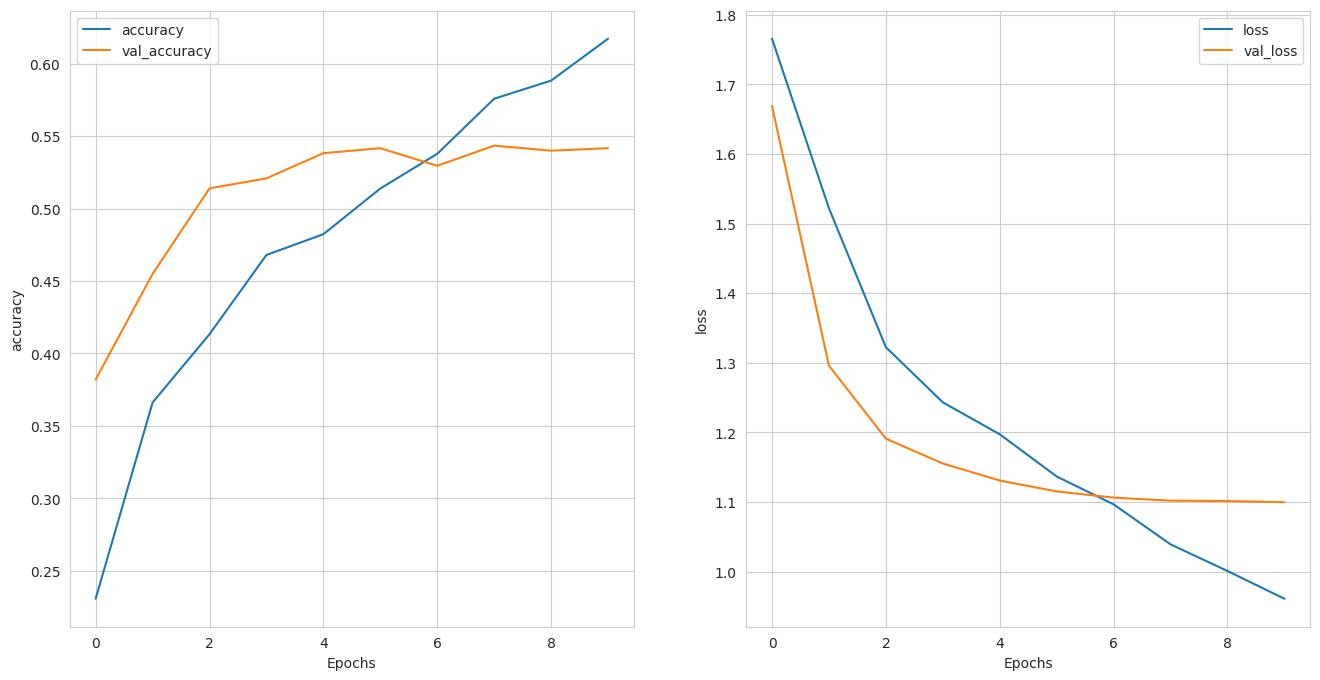

In [28]:
# Plot graphs
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_training_graphs(training_history, 'accuracy')
plt.subplot(1, 2, 2)
plot_training_graphs(training_history, 'loss')
plt.show()


77/77 [==============================] - 0s 4ms/step
Accuracy score: 0.5208
Precision: 0.5280
Recall: 0.5240
F1 Score: 0.5099


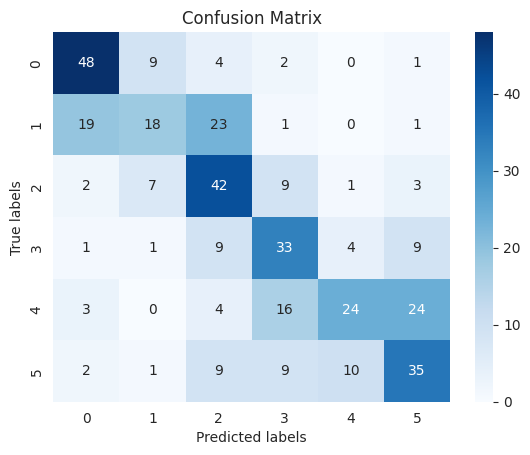

In [29]:
# Evaluate model
evaluate_model(model, test_dataset)

In [30]:
# Evaluate the model
model.evaluate(features_unlabeled)

# Generate predictions
pred = model.predict(features_unlabeled)

# Transform predictions to labels
labels = pd.DataFrame(np.argmax(pred, axis=1), columns=["difficulty"])
labels["difficulty"] = labels["difficulty"].map({0: "A1", 1: "A2", 2: "B1", 3: "B2", 4: "C1", 5: "C2"})
labels["id"] = labels.index
labels = labels[["id", "difficulty"]]

# Save to CSV
labels.to_csv('submission.csv', index=False)
from google.colab import files
files.download("submission.csv")

38/38 [==============================] - 0s 8ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>